# Decode DNA-segments back to the original file

# Imports

In [145]:
import random
import math
import numpy as np
import functools
import reedsolo
import matplotlib.pyplot as plt

# DNA requirements

In [2]:
def CheckBiochemicalRequirements(s, max_length=3, check=False): 
    if s.find((max_length+1)*'C') ==-1 & s.find((max_length+1)*'G') ==-1 & s.find((max_length+1)*'T')==-1 & s.find((max_length+1)*'A')==-1:
#         print('yes, no homopolymers')
        nr_CG = s.count('C')+s.count('G')
        per_CG=nr_CG/len(s)
        if (per_CG < 0.55) & (per_CG > 0.45):
#             print('Suitable CG content')
            check = True
#         else:
#             print('CG content not in accepted ranges')
#     else:
#         print('not a valid sequence: it contains homopolymers longer than three bases')
    return check

In [22]:
#check voor de lengte van de oligo toegevoegd, als dit niet klopt proberen te solven met reed-solomon
def check_oligo_length(s,length=152,check_lenght=False):
    if len(s) == length:
        check_length = True
    else:
        if len(s) < length:
            print('oligo length is too short')
        else:
            print('oligo length is too long')
    return check_length

# Convert DNA to binary

In [5]:
def DNA2Binary(s):
    bs = ""
    for x in s:
        if x == "A":
            bs = bs + "00"
        if x == "C":
            bs = bs + "01"
        if x == "G":
            bs = bs + "10"
        if x == "T":
            bs = bs + "11"
    return bs

In [33]:
def string_to_bytearray(bs):
    ba = bytearray(bs,'utf-8')
    return ba

# Reed-Solomon

In [48]:
def Reed_solo(ba):
    rsc = reedsolo.RSCodec(2)
    if rsc.check(ba):
        decoded_rs = rsc.decode(ba)[0]
    return decoded_rs

# Recover seed

In [8]:
def ideal_soliton(K) -> list: 
    # initialize with the first two values, p(0) = 0 and p(1) = 1/K
    probabilities = [0, 1/K]
    # calculate the rest of the values using p(i) = 1/(i*(i-1))
    probabilities += [1/(i*(i-1)) for i in range(2, K+1)]
    return probabilities 

In [9]:
def robust_soliton(K,c,delta) -> list:
    #initialize with the ideal distribution
    probabilities = ideal_soliton(K)
    # Define R
    R = c*(math.log(K/delta))*math.sqrt(K)
    # calculate the additional probabilities
    robust_probabilities = [0] + [R/(i*K) for i in range(1, int(K/R)-1)]
    robust_probabilities += [(R*math.log(R/delta))/K]
    robust_probabilities += [0 for i in range(int(K/R),K+1)]
    # add together
    probabilities = np.add(robust_probabilities, probabilities)
    #normalize 
    probabilities /= sum(probabilities)
    return probabilities

In [100]:
def recover_seed(decoded_rs, total_segments):
    prng = random.Random()
    droplet_seed = decoded_rs[0:32]
    prng.seed(droplet_seed)

    amount_recovery = prng.choices(range(0,101), robust_soliton(100,0.1,0.05), k = 1)[0]
#     assert amount_recovery == amount 
    #I can't think of a way to do this without having prior knowledge of the amount of stored data... something to discuss
    segment_indices = prng.sample(range(total_segments), k = amount_recovery)
#     segment_test = []
#     for i in segment_indices:
#         segment_test.append(data_bytearray[i])
# #     assert segment_test == segments
    return (amount_recovery, segment_indices)

# Solve Luby-transformations

In [11]:
input_data = [] # deze moet in de mainfile komen
def input_data(segment_indices, decoded_rs):
    segment = decoded_rs[32:len(decoded_rs)]
    segmentlist += [segment_indices, segment]
    return input_data

In [13]:
nr_segments = 5 #deze komt uit de extra oligo die we willen maken
output_data = {} # moet in de mainfile

def Decoding_step1and2(input_data, output_data):
    for droplet in input_data:
        segment_indices = droplet[0]
        XOR = droplet[1]
        remaining_segments = []
        for i in range(len(segment_indices)):
            if segment_indices[i] in output_data:
                dif = int(XOR,2) ^ int(output_data[segment_indices[i]],2)
                XOR = '{0:0{1}b}'.format(dif,len(droplet[1]))
            else:
                remaining_segments.append(segment_indices[i])    

        if len(remaining_segments)==1:
            output_data[remaining_segments[0]] = XOR
            newsolves=1
            while newsolves>0: 
                startsolves = len(output_data)
                Decoding_step1and2(input_data, output_data)
                endsolves = len(output_data)
                newsolves = endsolves-startsolves
    return output_data

# Van dit stuk hieronder weet ik niet of het ook gewoon in de def zou kunnen?                
## output_data = Decoding_step1and2(input_data, output_data)

##add in a check to see if all segments have been solved.
#are all values from 0 to last segment keys in the dictionary
if len(output_data)==nr_segments:
    solution = ''.join([output_data[x] for x in range(nr_segments)])
else:
    solution = 'solution could not be reached, use another more robust method'
solution


'solution could not be reached, use another more robust method'

# Unrandomize

In [14]:
def unrandomize(solution, keygenseed) -> bytearray:
    # unrandomize the message one byte at a time, using a known keygenseed.
    unrandomized = bytearray(len(solution))
    for i in range(len(solution)):
        key = generate_key(keygenseed)
        keygenseed += 1
        unrandomized[i] = key ^ solution[i]
    return unrandomized

# Return original file

In [15]:
def original_data(unrandomized):
    original_data = unrandomized.decode()
    return original_data

# Mainscript

In [38]:
with open("file.txt", 'r') as f:
    dropletlist = [line.rstrip('\n') for line in f]

def decode(dropletlist,K,c,delta,total_segments,):
    data = dropletlist
    #put the droplet list in variable data
    OKdroplets = []
    newlistcounter = 0
    for i in length(data):
        s = data[i]
        if CheckBiochemicalRequirements(s):
            newlistcounter += 1
            OKdroplets[newlistcounter]=s
    #put all droplets that have the correct biomedical requirements in variable OKdroplets
    checked_droplets = []
    newlistcounter = 0
    for j in length(OKdroplets):
        if check_oglio_length(OKdroplets):
            newlistcounter += 1
            checked_droplets[newlistcounter] = OKdroplets[j]
    #put all the OKdroplets that have the correct lenght in variable checked_droplets
    for k in length(checked_droplets):
        checked_droplets[k] = DNA2Binary(checked_droplets[k])
    #convert DNA to binary
    for l in length(checked_droplets):
        checked_droplets[k] = string_to_bytearray(checked_droplets[k])
    #get a list of byte arrays
    for l in lenght(checked_droplets):
        checked_droplets[k] = Reed_solo(checked_droplets[k])
    #Decode using reed-solomon
    """
    Ik weet even niet wat de bedoeling is met de recover seed. 
    Kunnen we het hier tijdens de vergadering over hebben?
    """
    probabilities = robust_solution(K,c,delta)
    #recover seed
    input_data = []
#     for m in length(checked_droplets):
        
   

In [106]:
data = dropletlist
total_segments=15399 # moet geen variabele meer zijn
#put the droplet list in variable data
OKdroplets = []

for strand in data:
    if CheckBiochemicalRequirements(strand):
        if check_oligo_length(strand):
            OKdroplets.append(strand)
        
#put all the OKdroplets that have the correct lenght in variable checked_droplets
simplified_droplets = []
rsc = reedsolo.RSCodec(2)
for strand in OKdroplets:
    binary_strand = DNA2Binary(strand)
    bytearray_strand = string_to_bytearray(binary_strand) 
    if rsc.check(bytearray_strand):
#         checked_strand = Reed_solo(bytearray_strand) gives an error # not implemented/errors are not fixed
        segment_amount, segment_indices = recover_seed(bytearray_strand, total_segments)
        payload = bytearray_strand[32:288]
        simplified_droplets.append((segment_indices, payload))

output_data = {}
output_data = Decoding_step1and2(simplified_droplets, output_data)
    


In [170]:
simplified_droplets

[([14179, 11227, 8722, 6180, 5001, 4489, 6995, 1154, 8239, 8453, 8855, 14781],
  bytearray(b'1111000010111101111010100100000111011010111010111100001100100110100100110101111011011101101001010000011100110010000011000101100101011000111100110101001100000101000110101110000001001101100110101111101011100001010001111011111101101110000011100110111110000010')),
 ([14346],
  bytearray(b'0110101011111110101001001000111100011011100000010110110001100011010001111001000010000101111100011111011111000010100111101100111111001011001001000110000110010010001111000000111010100000010111101010001010100001111000110010000110001010000110111001100111110100')),
 ([6115, 12564, 13914],
  bytearray(b'1101000100001110010111010111001110101011000010000110101110100001000011000001100000101001111100001101011001100111011101111101100010001111100001111110010010100110001111110111100001101111010000111001100110100111101110110000101111110000000100100110000010010110')),
 ([9239, 12815],
  bytearray(b'011000111001100100110000111000

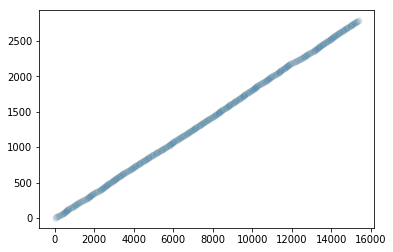

In [153]:
xl=[]
for x in output_data:
    xl.append(x)
xl.sort()
plt.scatter(xl, range(len(xl)), alpha=0.01)

In [168]:
present_seg = []
for seg_ind in simplified_droplets:
    segs = seg_ind[0]
    for ind in segs:
        if ind not in present_seg:
            present_seg.append(ind)            

In [169]:
present_seg == [x for x in range(15399)]
15399-len(present_seg)

18

In [110]:
if len(output_data)==total_segments:
    solution = ''.join([output_data[x] for x in range(total_segments)])
else:
    solution = 'solution could not be reached, use another more robust method'
solution, len(output_data)

('solution could not be reached, use another more robust method', 2793)

In [129]:
nr_segments= total_segments

matrix = np.zeros([len(simplified_droplets),nr_segments+1], dtype=np.int64)
for i in range(len(simplified_droplets)):
    segment_indices = simplified_droplets[i][0]
    payload = int(simplified_droplets[i][1],2)
#     print(segment_indices, payload))
    matrix[i,segment_indices] = 1
    matrix[i,nr_segments] = payload

## Solve matrix to RREF
#result = rref(matrix)


OverflowError: int too big to convert

In [116]:
simplified_droplets[1][0]

[14346]

In [ ]:
if len(result[1])==nr_segments:
    solution = ''.join(['{0:0{1}b}'.format(x,4) for x in result[0][result[1],-1]])
    if solution == og_data:
        print("succesfull recovery of sequence:",solution)
    else:
        print("enough droplets collected but solution is incorrect")
else:
    solution = 'solution could not be reached, more droplets are needed'
    print(solution)